In [1]:
# General libraries
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

# Scikit Learn libraries
from sklearn.model_selection import train_test_split

# Utils functions
from utils.utils import compare_models, plot_score_dist, compare_confidence_intervals, five_two

In [2]:
data_folder_path = '../data/'

data_path = data_folder_path + 'complex_processed_data.csv'
standardized_data_path = data_folder_path + 'complex_processed_standardized_data.csv'
standardized_poutliers_removed_data_path = data_folder_path + 'complex_processed_standardized_outliers_removed_data.csv'

df_solubility = pd.read_csv(standardized_data_path)

In [3]:
# Split dataset into X and Y for machine learning

df_sol_X = df_solubility.copy()
df_sol_X.drop(columns=['solubility'], axis=1, inplace=True)

df_sol_y = df_solubility[['solubility']]

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
                        df_sol_X, df_sol_y, 
                        train_size = 0.8,
                        test_size = 0.2,
                        random_state = 10
                        )

In [5]:
def load_model(model):
    models_folder = '../models/'
    return joblib.load(models_folder + model + '_model.joblib')

In [6]:
#1000 to 10.000 did not show significative differences
#size 2270 based on the paper: https://www.econstor.eu/bitstream/10419/67820/1/587473266.pdf
random_state_list = list(np.random.randint(low = 1,high=5000,size=2270))

## Linear Regression VS SVR

In [7]:
five_two(
    reg1=load_model('lr'),
    reg2=load_model('svr'),
    X=x_train.copy(),
    y=y_train.copy(),
    metric='default'
    )

Fold  1 score difference = -0.022542
Fold  2 score difference = -0.224828
Fold  1 score difference = -0.194397
Fold  2 score difference = -0.140636
Fold  1 score difference = -0.194014
Fold  2 score difference = -0.135613
Fold  1 score difference = -0.108558
Fold  2 score difference = -0.142868
Fold  1 score difference = -0.247571
Fold  2 score difference = -0.134340
Regression 1 mean score and stdev : 0.027767 + 0.083745
Regression 2 mean score and stdev : 0.182304 + 0.037843
Score difference mean + stdev : -0.154537 + 0.061136
t_value for the current test is -0.288107


mean_score_1 0.005967878815498694, std 0.10734251307269457
mean_score_2 0.28214950170615, std 0.06285851189417922
Ttest_relResult(statistic=-126.88281597416689, pvalue=0.0)
P value menor ou igual a 0.05


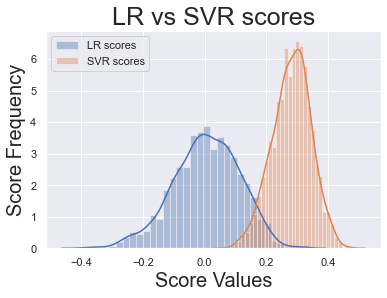

In [8]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('lr'),
    reg2=load_model('svr'),
    X=x_test.copy(),
    y=y_test.copy(),
    random_state_list = random_state_list
)


plot_score_dist(reg1_scores, reg2_scores, 'LR', 'SVR')

In [9]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

-0.2277092201841202
0.19787019064005087
0.15024884789802617
0.4010954131830898


## Linear Regression VS XGBoost

In [11]:
five_two(
    reg1=load_model('lr'),
    reg2=load_model('xgboost'),
    X=x_train.copy(),
    y=y_train.copy(),
    metric='default'
    )

Fold  1 score difference = -0.016860
Fold  2 score difference = -0.191181
Fold  1 score difference = -0.167404
Fold  2 score difference = -0.086584
Fold  1 score difference = -0.184966
Fold  2 score difference = -0.149453
Fold  1 score difference = -0.016263
Fold  2 score difference = -0.117314
Fold  1 score difference = -0.246096
Fold  2 score difference = -0.116470
Regression 1 mean score and stdev : 0.027767 + 0.083745
Regression 2 mean score and stdev : 0.157026 + 0.029358
Score difference mean + stdev : -0.129259 + 0.070697
t_value for the current test is -0.208816


mean_score_1 0.005967878815498694, std 0.10734251307269457
mean_score_2 0.25139232425248104, std 0.0732280666492845
Ttest_relResult(statistic=-143.17786071369517, pvalue=0.0)
P value menor ou igual a 0.05


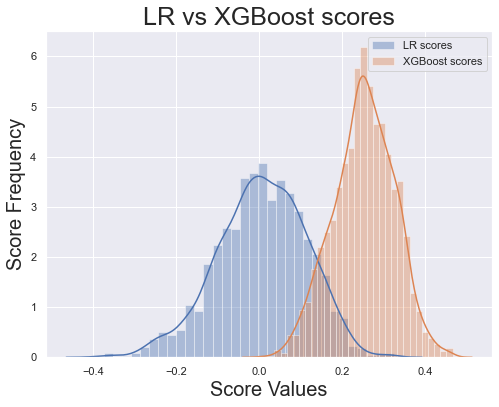

In [12]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('lr'),
    reg2=load_model('xgboost'),
    X=x_test.copy(),
    y=y_test.copy(),
    random_state_list = random_state_list
)

plot_score_dist(reg1_scores, reg2_scores, 'LR', 'XGBoost')

In [13]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

-0.2277092201841202
0.19787019064005087
0.10227614631588242
0.3866808381223478


## SVR VS XGboost

In [14]:
five_two(
    reg1=load_model('svr'),
    reg2=load_model('xgboost'),
    X=x_train.copy(),
    y=y_train.copy(),
    metric='default'
    )

Fold  1 score difference = 0.005682
Fold  2 score difference = 0.033647
Fold  1 score difference = 0.026993
Fold  2 score difference = 0.054052
Fold  1 score difference = 0.009048
Fold  2 score difference = -0.013840
Fold  1 score difference = 0.092295
Fold  2 score difference = 0.025555
Fold  1 score difference = 0.001476
Fold  2 score difference = 0.017870
Regression 1 mean score and stdev : 0.182304 + 0.037843
Regression 2 mean score and stdev : 0.157026 + 0.029358
Score difference mean + stdev : 0.025278 + 0.028621
t_value for the current test is 0.218509


mean_score_1 0.28214950170615, std 0.06285851189417922
mean_score_2 0.25139232425248104, std 0.0732280666492845
Ttest_relResult(statistic=23.42726454248609, pvalue=6.968776648537953e-109)
P value menor ou igual a 0.05


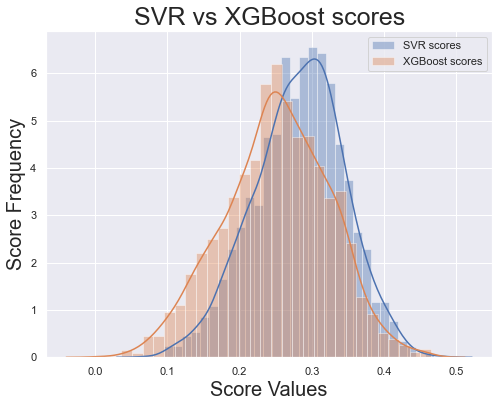

In [15]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('svr'),
    reg2=load_model('xgboost'),
    X=x_test.copy(),
    y=y_test.copy(),
    random_state_list = random_state_list
)

plot_score_dist(reg1_scores, reg2_scores, 'SVR', 'XGBoost')

In [16]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

0.15024884789802617
0.4010954131830898
0.10227614631588242
0.3866808381223478


mean_score_1 -0.5327078206814636, std 0.13421141728757183
mean_score_2 -0.5983785509203783, std 0.15635181798090472
Ttest_relResult(statistic=23.427264542486085, pvalue=6.968776648538347e-109)
P value menor ou igual a 0.05


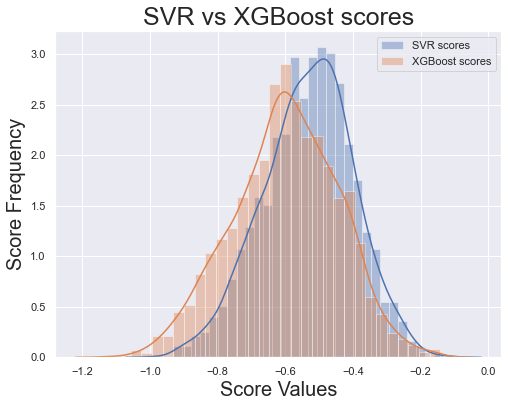

In [17]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('svr'),
    reg2=load_model('xgboost'),
    X=x_test.copy(),
    y=y_test.copy(),
    metric="adj_r2",
    random_state_list = random_state_list
)

plot_score_dist(reg1_scores, reg2_scores, 'SVR', 'XGBoost')

In [18]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

-0.8143335409744846
-0.2787422259063759
-0.9167617416498727
-0.3095192915766087
